### 1. Data Preprocessing

- Load the driving log 
- downsample 0.00 steering
- Create a new array including L and R cameras in sequence
- shuffle array

In [1]:
import numpy as np
from numpy import genfromtxt
import sys
import matplotlib.image as mpimg

print("Loading metadata from driving_log.csv...")
file_format = [('center','S64'),('left','S64'),('right','S64'),('steering', 'f8'),('throttle', 'f8')]
metadata = genfromtxt('data/driving_log.csv', dtype=file_format, delimiter=',', skip_header=1, usecols=(0, 1, 2, 3, 4))
metadata['steering'] = np.round(metadata['steering'], decimals=2)
metadata['throttle'] = np.round(metadata['throttle'], decimals=2)
print("Load {0} Records".format(len(metadata)))

# How to read image files
#######################################################
def image_file(name):
    return "data/{0}".format(name.decode("utf-8").strip())

# Check that the data is valid and readable.
#######################################################
def scrub_data(data):
    removals = []
    # Check Image file names
    for i in range(len(data)):
        c = data[i]['center']
        l = data[i]['left']
        r = data[i]['right']
        try:
            c.decode('utf-8')
            l.decode('utf-8')
            r.decode('utf-8')
        except:
            print("Item {0} Corrupted".format(i))
            removals.append(i)
            
    if len(removals) > 0:
        print("Removing {} Records...".format(len(removals)))
        data = np.delete(data, removals, 0)
    # Check Image files for corruption
    print("Checking for unreadable images...")
    removals = []
    for i in range(len(data)):
        c = image_file(data[i]['center'])
        l = image_file(data[i]['left'])
        r = image_file(data[i]['right'])
        try:
            mpimg.imread(c)
            mpimg.imread(l)
            mpimg.imread(r)
        except:
            print("Item {0} Corrupted".format(i))
            removals.append(i)
    if len(removals) > 0:
        print("Removing {} Records...".format(len(removals)))
        data = np.delete(data, removals, 0)
    print("Scrubbing done.")
    return data


Loading metadata from driving_log.csv...
Load 25968 Records


In [2]:
# Downsample 0.00 steering by find sequences of 0.00 steering and
# keeping the first 2, middle 2 and last 2 images of the sequence
##################################################################
def downsample_zeros(data):
    removals = []
    cache = []
    sequences = []
    for r in range(len(data)):
        if data[r]['steering'] == 0.00:
            cache.append(r)
        else:
            size = len(cache)
            sequences.append(size)
            if size > 9:
                #del cache[-1:]
                #del cache[:1]
                rem = round(len(cache)/2)
                del cache[rem]
                # Remove remainding entries from the data
                #print("Removing", cache)
                removals = removals + cache
                cache = []
    #print("Zero Sequences", sequences)
    print('Removals', len(removals))
    return np.delete(data, removals, axis=0)

#metadata = scrub_data(metadata)
cleansed = downsample_zeros(metadata)
print("Keep", len(cleansed), "Records")

Removals 10874
Keep 15094 Records


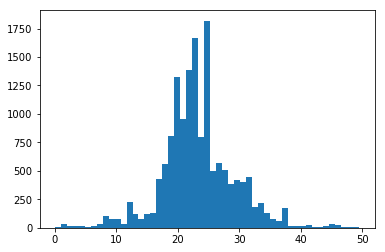

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1)
a = plt.hist(cleansed['steering']*25+25, bins=51)

In [4]:
### Steering Stats
#mean, stddev, median = np.mean(cleansed['steering']), np.std(cleansed['steering']), np.median(cleansed['steering'])
mean1, stddev1, median1 = np.mean(metadata['steering']), np.std(metadata['steering']), np.median(metadata['steering'])
mean1, stddev1, median1

(-0.036724531749657383, 0.21220568783191485, 0.0)

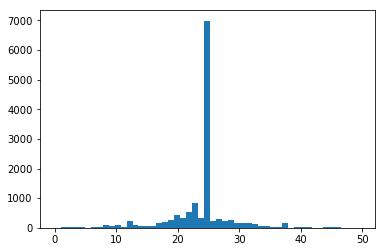

In [8]:
plt.figure(1)
a = plt.hist((metadata['steering'])*25+25, bins=51)

### 2. Create a sequence including the L, R Cameras

Assume the steering for the side cameras is the an adjusted version of the center camera:

- $\ C_{steering} = 0: L_{steering}=1.0, R_{steering}=-1.0$
- $\ C_{steering} > 0: L_{steering}=C, R_{steering}=1.0-C$
- $\ C_{steering} < 0: L_{steering}=1.0+C, R_{steering}=C$

Where 'adjustment' is some factor based on the camera position. Starting assumption is 1

In [9]:
def process_side_cameras(data):
    record_types=[('image','S64'),('steering','f8'),('throttle','f8')]
    augmented = np.empty([], dtype=record_types)
    cache = []
    samples = len(data)
    
    for i in range(samples):
        c_steering = data[i]['steering']
        #Calculate steering for side cameras
        c = np.array((data[i]['center'], c_steering, data[i]['throttle']), dtype=record_types)
        cache.append(c)
        if c_steering == 0.0:
            l_steering = 1.0
            r_steering = -1.0
        else:
            if c_steering >= 0.25:
                l_steering = c_steering
                r_steering = c_steering - 1.0
                l = np.array((data[i]['left'], l_steering, data[i]['throttle']), dtype=record_types)
                cache.append(l)
                r = np.array((data[i]['right'], r_steering, data[i]['throttle']), dtype=record_types)
                cache.append(r)
            else:
                if c_steering <= -0.25:
                    l_steering = 1.0 + c_steering
                    r_steering = c_steering
                    l = np.array((data[i]['left'], l_steering, data[i]['throttle']), dtype=record_types)
                    cache.append(l)
                    r = np.array((data[i]['right'], r_steering, data[i]['throttle']), dtype=record_types)
                    cache.append(r)

        # Transfer the cache to the array every 100 items
        if i == 0:
            continue
        if i % 100 == 0:
            augmented = np.append(augmented, cache)
            cache = []
            print("{0}, ".format(i), end="")
    if i % 100 > 0:
        print("residual cache",len(cache))
        augmented = np.append(augmented, cache)
    return augmented

augmented = process_side_cameras(cleansed)
print(len(augmented))

100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, residual cache 92
11130


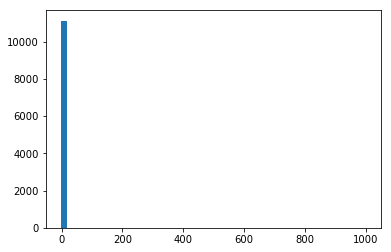

In [11]:
## Check the distribution of data

plt.figure(2)
a = plt.hist(augmented['steering'], bins=51)

### 3. Additional augmentation using image translations

#### TODO: Find a way to rotate images about the user's prespective (bottom center of image)

In [13]:
# Adjust steering based on viewport
# Put it in a separate function so its easy to change the scaling model
##########################################################################
def adjust_steering(c):
    # Chosen adjustment is ~ 1 Std Dev of sample distribution
    # Cap it at the maximum steering angle
    if c == 0.0:
        d = 0.1905
        l = 0
        r = 0
    else:
        d = 0.1905
        if c < 0.0:              # left turn
            l = (1-d) * c        # turn less
            r = max((1+d) * c, c)# turn more
        else:                    # right turn
            l = min((1+d) * c, c)# turn more
            r = (1-d) * c        # turn less
        
    return l, r

def adjust_steering_simple(c):
    residual = 0 * 0.1905 * np.random.uniform()
    multiplier = abs(c)
    base_adj = 0.5
    l = multiplier * base_adj + residual
    r = -1 * (multiplier * base_adj + residual)
    return l, r

def load_images(src, labels):
    global viewport_labels
    img_cache = []
    label_cache = []
    img_array = None
    label_array = None
    for i in range(len(src)):
        img = mpimg.imread( image_file(src[i]) )
        # Split the image into three 100,100 viewports to augment samples and resize to 224,224
        img_c, img_l, img_r = get_viewports(img)
        steer_c = labels[i]
        steer_l, steer_r = adjust_steering(steer_c)
        if i == 0:
            img_array = np.array([img_c, img_l, img_r])
            label_array = np.array([steer_c, steer_l, steer_r])
        else:
            img_cache = img_cache + [img_c, img_l, img_r]
            label_cache = label_cache + [steer_c, steer_l, steer_r]
    try:
        img_array = np.append(img_array, img_cache, axis=0)
        label_array = np.append(label_array, label_cache, axis=0)
        if viewport_labels is None:
            viewport_labels = label_array
        else:
            viewport_labels = np.append(viewport_labels, label_array)
    except:
        print("Error loading images", len(img_array), "Cache", len(img_cache))
    return img_array, label_array

def load_LR_labels(x_data, y_data):
    label_cache = []
    img_cache = []
    label_array = None
    img_array = None
    for i in range(len(y_data)):
        img = x_data[i].decode("utf-8").strip()
        steer_c = y_data[i]
        img_c = img + "#C"
        img_l = img + "#L"
        img_r = img + "#R"
        steer_l, steer_r = adjust_steering_simple(steer_c)
        if steer_c == 0.0:
            new_images = [img_c]
            new_labels = [steer_c]
        else:
            new_images = [img_c, img_l, img_r]
            new_labels = [steer_c, steer_l, steer_r]
        if i == 0:
            label_array = np.array(new_labels)
            img_array = np.array(new_images)
        else:
            label_cache = label_cache + new_labels
            img_cache   = img_cache   + new_images
    try:
        label_array = np.append(label_array, label_cache, axis=0)
        img_array   = np.append(img_array, img_cache, axis=0)
    except:
        print("Error loading labels", len(label_array), "Cache", len(label_cache))
    print("Lengths", len(img_array), len(label_array))
    return img_array, label_array


In [22]:
from ImageProcessing import balance_dataset, data_binning, transform_image
import matplotlib.image as mpimg

# Balance the dataset so each class is equally represented
def balancing(x_data, y_data):
    x_train, y_train, = x_data, y_data
    y_train = np.round(y_train*100)+100
    n_classes = 201
    bins, X_train_binned, y_train_binned, bin_count = data_binning(x_train, y_train, n_classes)
    # Sample metrics
    mean = np.mean(bin_count)
    median = np.median(bin_count)
    bin_count_array = np.array(bin_count)
    top10 = np.argpartition(bin_count_array, -2)[-5:]
    top_counts = bin_count_array[top10]
    target_count = int(np.mean(top_counts))
    target_count = mean
    print("Top 10 classes", top10)
    print("Top 10 counts", top_counts, "Target Count", target_count, mean)

    #Downsample to mean
    print("Removing samples over target count...")
    removal_list = None
    for i in range(n_classes):
        if bin_count[i] > target_count:
            removal_count = int((bin_count[i] - target_count) )
            print("removing",removal_count, " from class ", i)
            #generate a list of random removals
            removal_idx = np.random.choice(bin_count[i], size=removal_count, replace=False)
            if removal_list is None:
                removal_list = bins[i][removal_idx.tolist()]
            else:
                removal_list = np.append(removal_list, bins[i][removal_idx.tolist()])
    #Now remove the targeted samples
    x_train = np.delete(x_train, removal_list, axis=0)
    y_train = np.delete(y_train, removal_list, axis=0)
    
    # minimum times a sample should be seen
    #Now Add new samples for under average classes
    print("Adding samples to target count...")
    for i in range(n_classes):
        # Just augment classes where count > median
        if bin_count[i] >= 1 and bin_count[i] < target_count:
            add_count = int((target_count-bin_count[i]))
            #pick images at random to copy n times
            src_idx = np.random.choice(bin_count[i], size=add_count, replace=add_count>bin_count[i])
            print("class", i, "copies", add_count, end="\t")
            new_img_list = []
            new_label_list = []
            for src in range(add_count):
                #For now, just copy existing images. In the future, shift them and adjust the angle appropriately
                target_file = X_train_binned[i][src_idx[src]]
                new_img_list.append(target_file)
                new_label_list.append(i)
            x_train = np.append(x_train, new_img_list)
            y_train = np.append(y_train, new_label_list)
    print("\nBalancing Sample size", len(x_train))
    return x_train, (y_train-100)/100

x_data, y_data = metadata['center'], metadata['steering']
x_train, y_train = balancing(x_data, y_data)
print("Balanced", len(y_train))

Top 10 classes [ 50  49  96  98 100]
Top 10 counts [  10   10  369  409 9255] Target Count 81.7960199005 81.7960199005
Removing samples over target count...
removing 53  from class  73
removing 24  from class  75
removing 69  from class  78
removing 26  from class  79
removing 98  from class  81
removing 44  from class  83
removing 178  from class  85
removing 98  from class  86
removing 186  from class  88
removing 24  from class  89
removing 165  from class  91
removing 102  from class  92
removing 247  from class  93
removing 119  from class  94
removing 30  from class  95
removing 287  from class  96
removing 327  from class  98
removing 9173  from class  100
removing 14  from class  101
removing 61  from class  104
removing 17  from class  105
removing 16  from class  106
removing 16  from class  107
removing 115  from class  109
removing 29  from class  110
removing 47  from class  113
removing 61  from class  117
removing 181  from class  118
Adding samples to target count...
cl

(-0.027027012263403705, 0.34119424681574917)

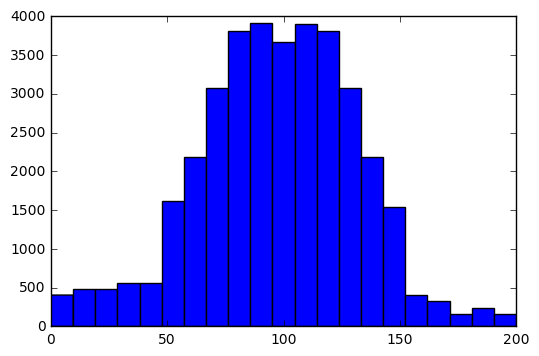

In [29]:
plt.figure(2)
a = plt.hist(y_train*100+100, bins=21)

#Check for wonky values in image names
#augmented = np.delete(augmented, 0, 0)
#for i in range(1,len(augmented)):
#    print(i, augmented[i]['image'].decode('utf-8'), end="|")
#Remove the first record
#augmented = np.delete(augmented, 0, 0)
np.mean(y_train), np.std(y_train)

Lengths 22061 22061
W/Viewports 22061


(-0.012654911382076967, 0.13997618443144091)

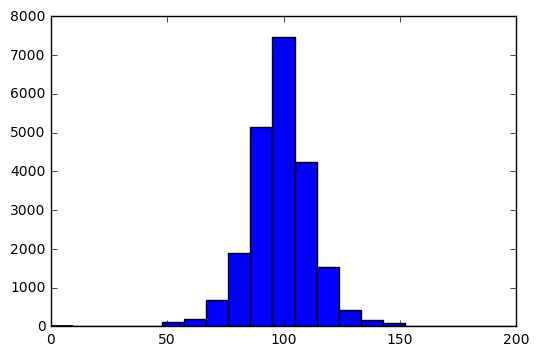

In [50]:
x_train, y_train = cleansed['center'], cleansed['steering']
x_train, y_train = load_LR_labels(x_train, y_train)#load_labels_only(cleansed['steering'])
print('W/Viewports', len(y_train))

plt.figure(2)
a = plt.hist(y_train*100+100, bins=21)

np.mean(y_train), np.std(y_train)

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.utils import shuffle

def create_datasets(x_data, y_data):
    # Create Training and validation sets from the data
    n_classes = 201
    x_train, y_train = shuffle(x_data, y_data)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.10, random_state=42)
    return x_train, y_train, x_val, y_val, n_classes

x_train, y_train, x_val, y_val, n_classes = create_datasets(x_train, y_train)

In [ ]:
#Check for wonky values in image names
for i in range(len(x_train)):
    print(i, x_train[i].decode('utf-8'), end="|")